# 02 - Basic Operations and Basic Concepts: the Jacobian
In this second part of the "Basic Operations and Basic Concepts" tutorials, we will be discussing the Jacobian matrices.

### Definition
Mathematically, Jacobian matrices are nothing but first-order derivatives. Suppose we have a function $\mathbf{y}=f(\mathbf{x})$ where $\mathbf{y}\in R^m$ and $\mathbf{x}\in R^n$, and the Jacobian matrix is denoted as $\mathbf{J}$, we have $\mathbf{J}_{ij}=\frac{\partial y_i}{\partial x_j}$.

In the context of diffuse optics, we can understand it as "how much does the boundary measurement change, given some change of optical property at a location", and the boundary measurement can be light intensity, log intensity, phase, etc. For that reason, the Jacobian matrix is also commonly referred to as the "sensitivity matrix".

### Born and Rytov approximation
You may have seen these two terms in literature, so let's make a brief clarification here, especially in terms of how NIRFASTerFF handles them. For simplicity, let's look at a scalar function $y=f(x)$. 

Born approximation simply says,
$$\Delta y=f'(x)\Delta x$$
In the case of vector/matrix functions, the derivative becomes the Jacobian matrix. Rytov approximation can be understood as taking an extra step before the first-order approximation: $\log y=\log f(x)$. This gives, by chain rule,
$$\Delta\log y=\frac{1}{f(x)}f'(x)\Delta x$$

We can make a few observations: 1) the Jacobian matrix in Rytov approximation is simply the Jacobian matrix in Born approximation normalized by the boundary measurements (hence the "normalize" argument in the Jacobian calculation function); 2) the left-hand side of Rytov approximation actually coincides with "changes of optical density", if you are familiar with the fNIRS terminologies. It is far more common to use Rytov approximation in the DOT community, and we will focus on that in this tutorial.

## CW and FD
Let's start with, again, a 2D example mesh.

In [1]:
import sys
sys.path.insert(1, '../')
import nirfasterff as ff # ff is short for fast and furious
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# load mesh
mesh = ff.base.stndmesh()
mesh.from_file('../meshes/standard/circle2000_86_stnd')
# define the grid
xgrid = np.arange(-45., 45, 2)
ygrid = np.arange(-45., 45, 2)
mesh.gen_intmat(xgrid, ygrid)
# calculate the CW Jacobian
J = mesh.jacobian()[0]
# If no arguments are given, it is CW, and normalized (Rytov)

Fixed sources
Sources integration functions loaded
Fixed detectors
Detectors integration functions loaded
Calculating direct field...
Calculating adjoint field...
Integrating...


Let's visualize two channels, and see what we can observe

/tmp/ipykernel_4663/3362915099.py:3: RuntimeWarning: divide by zero encountered in log
  h1 = ax1.imshow(np.log(np.abs(J[2,:].reshape((45,45),order='F'))), origin='lower')
/tmp/ipykernel_4663/3362915099.py:7: RuntimeWarning: divide by zero encountered in log
  h2 = ax2.imshow(np.log(np.abs(J[6,:].reshape((45,45),order='F'))), origin='lower')


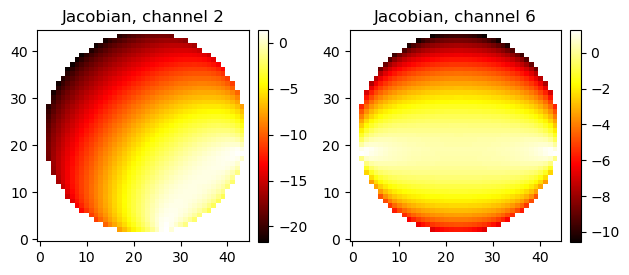

In [3]:
fig, (ax1, ax2) = plt.subplots(1,2)
plt.set_cmap('hot')
h1 = ax1.imshow(np.log(np.abs(J[2,:].reshape((45,45),order='F'))), origin='lower')
ax1.set_title('Jacobian, channel 2')
fig.colorbar(h1, fraction=0.046, pad=0.04)

h2 = ax2.imshow(np.log(np.abs(J[6,:].reshape((45,45),order='F'))), origin='lower')
ax2.set_title('Jacobian, channel 6')
fig.colorbar(h2, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

By default, the Jacobian matrix are calculated with regard to the absorption coefficients. In the matrix, each row contains the "sensitivity information" of a channel at each voxel, but vectorized in the Fortran order (for compatibility with Matlab). Therefore, the size of the Jacobian matrix is number-of-channels by number-of-voxels. 

We can see that the sensitivity, when visualized, takes a curved shape, and this is why we sometimes also refer to it as the "banana".

Let's also do a bit of validation of its correctness. By definition, if we multiply the Jacobian with a $\Delta\mu_a$ vector, or if we change the mua field of the mesh by $\Delta\mu_a$ and calculate how much the boundary measurement changes (the perturbation method, as it is sometimes called), they should be approximately the same. We can do a simple test using a $\Delta\mu_a$ vector where all elements are the same, or "flat field imaging".

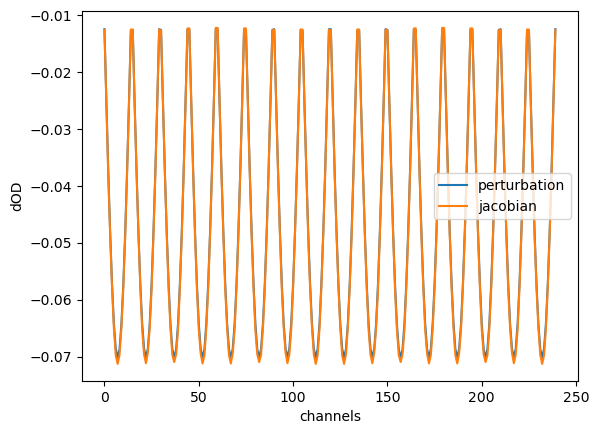

In [4]:
# duplicate the mesh
mesh2 = ff.base.stndmesh()
mesh2.from_copy(mesh)
# change the optical properties
mesh2.change_prop(-1, [mesh.mua[0]+0.01*mesh.mua[0], mesh.mus[0], mesh.ri[0]]) # 1% change
# calculate the forward data and then the difference
data1 = mesh.femdata(0)[0]
data2 = mesh2.femdata(0)[0]
d_data_pert = np.log(data2.amplitude) - np.log(data1.amplitude)
# Now use the Jacobian method
dmua = 0.01*mesh.mua[0]*np.ones(xgrid.size * ygrid.size)
d_data_jacobian = J @ dmua
# Plot them together
plt.figure()
plt.plot(d_data_pert)
plt.plot(d_data_jacobian)
plt.legend(['perturbation', 'jacobian'])
plt.xlabel('channels')
plt.ylabel('dOD')
plt.show()

It is used less often, but what we can also do is to calculate the Jacobian matrix with regard to the reduced scattering coefficients. This is controlled by the "mus" switch in the mesh.jacobian funcion. When it is enabled, the resulting Jacobian matrix will be twice as wide. If we denote it as $[J_1, J_2]$, $J_1$ contains the sensitivity to $\mu_s'$, and $J_2$ is exactly the same as what we previously calculated.

Let's also validate the new Jacobian using, again, flat field imaging.

Calculating direct field...
Calculating adjoint field...
Integrating...


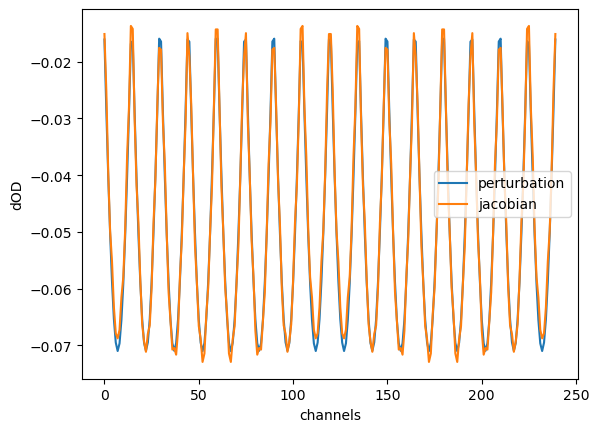

In [5]:
# calculate the Rytov Jacobian, notice that we set argument mus to true
J = mesh.jacobian(mus=True)[0]
# let's look only at the mus part
J1 = J[:,:xgrid.size * ygrid.size]
# duplicate the mesh
mesh2 = ff.base.stndmesh()
mesh2.from_copy(mesh)
# change the optical properties
mesh2.change_prop(-1, [mesh.mua[0], mesh.mus[0]+0.01*mesh.mus[0], mesh.ri[0]]) # 1% change
# calculate the forward data and then the difference
data1 = mesh.femdata(0)[0]
data2 = mesh2.femdata(0)[0]
d_data_pert = np.log(data2.amplitude) - np.log(data1.amplitude)
# Now use the Jacobian method
dmusp = 0.01*mesh.mus[0]*np.ones(xgrid.size * ygrid.size)
d_data_jacobian = J1 @ dmusp
# Plot them together
plt.figure()
plt.plot(d_data_pert)
plt.plot(d_data_jacobian)
plt.legend(['perturbation', 'jacobian'])
plt.xlabel('channels')
plt.ylabel('dOD')
plt.show()

Let's now move on to frequency domain. The ideas are exactly the same, except that we have yet another piece of information, the phase. The resulting Jacobian will be organized in an interleaved pattern, as in, the odd number rows (counting from 1) are derivatives of the amplitude (or its log), whereas the even number rows are derivatives of the phase (**NO** log). Be noted that the switch mus will be ignored here: the Jacobian will be always be calculated with regard to both reduced scattering (left half) and absorption (right half).

Calculating direct field...
Calculating adjoint field...
Integrating...


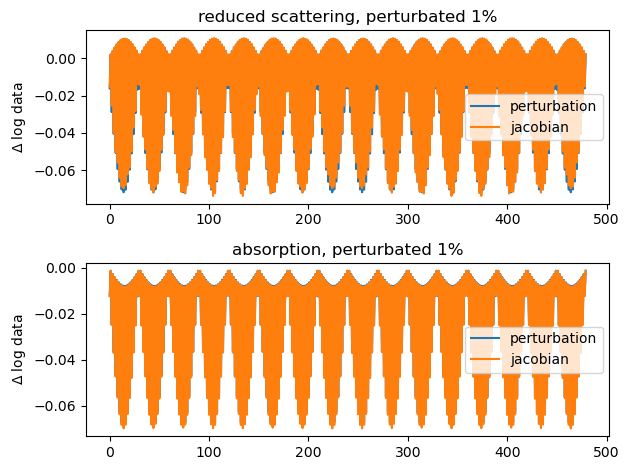

In [6]:
# calculate the Jacobian at 100MHz
J = mesh.jacobian(1e8)[0]
# let's separate the two halves
J1 = J[:, :xgrid.size * ygrid.size]
J2 = J[:, xgrid.size * ygrid.size:]

# make a copy
mesh2 = ff.base.stndmesh()
mesh2.from_copy(mesh)
# change the optical properties, musp
mesh2.change_prop(-1, [mesh.mua[0], mesh.mus[0]+0.01*mesh.mus[0], mesh.ri[0]]) # 1% change
# calculate the forward data and then the difference
data1 = mesh.femdata(1e8)[0]
data2 = mesh2.femdata(1e8)[0]
d_data_pert1 = np.c_[np.log(data2.amplitude) - np.log(data1.amplitude), (data2.phase - data1.phase)/180*np.pi] # phase converted to radian
d_data_pert1 = d_data_pert1.flatten()
# Now use the Jacobian method
dmusp = 0.01*mesh.mus[0]*np.ones(xgrid.size * ygrid.size)
d_data_jacobian1 = J1 @ dmusp

# repeat for mua
mesh2 = ff.base.stndmesh()
mesh2.from_copy(mesh)
# change the optical properties, mua
mesh2.change_prop(-1, [mesh.mua[0]+0.01*mesh.mua[0], mesh.mus[0], mesh.ri[0]]) # 1% change
# calculate the forward data and then the difference
data1 = mesh.femdata(1e8)[0]
data2 = mesh2.femdata(1e8)[0]
d_data_pert2 = np.c_[np.log(data2.amplitude) - np.log(data1.amplitude), (data2.phase - data1.phase)/180*np.pi] # phase converted to radian
d_data_pert2 = d_data_pert2.flatten()
# Now use the Jacobian method
dmua = 0.01*mesh.mua[0]*np.ones(xgrid.size * ygrid.size)
d_data_jacobian2 = J2 @ dmua
# plot
fig, (ax1, ax2) = plt.subplots(2)

ax1.plot(d_data_pert1)
ax1.plot(d_data_jacobian1)
ax1.set_title('reduced scattering, perturbated 1%')
ax1.set_ylabel('$\\Delta$ log data')
ax1.legend(['perturbation', 'jacobian'])

ax2.plot(d_data_pert2)
ax2.plot(d_data_jacobian2)
ax2.set_title('absorption, perturbated 1%')
ax2.set_ylabel('$\\Delta$ log data')
ax2.legend(['perturbation', 'jacobian'])

plt.tight_layout()
plt.show()

If we have a look a the bananas at channel 2,

/tmp/ipykernel_4663/3861022487.py:3: RuntimeWarning: divide by zero encountered in log
  h1 = axs[0,0].imshow(np.log(np.abs(J1[2*2,:].reshape((45,45),order='F'))), origin='lower')
/tmp/ipykernel_4663/3861022487.py:7: RuntimeWarning: divide by zero encountered in log
  h2 = axs[0,1].imshow(np.log(np.abs(J1[2*2+1,:].reshape((45,45),order='F'))), origin='lower')
/tmp/ipykernel_4663/3861022487.py:11: RuntimeWarning: divide by zero encountered in log
  h3 = axs[1,0].imshow(np.log(np.abs(J2[2*2,:].reshape((45,45),order='F'))), origin='lower')
/tmp/ipykernel_4663/3861022487.py:15: RuntimeWarning: divide by zero encountered in log
  h4 = axs[1,1].imshow(np.log(np.abs(J2[2*2+1,:].reshape((45,45),order='F'))), origin='lower')


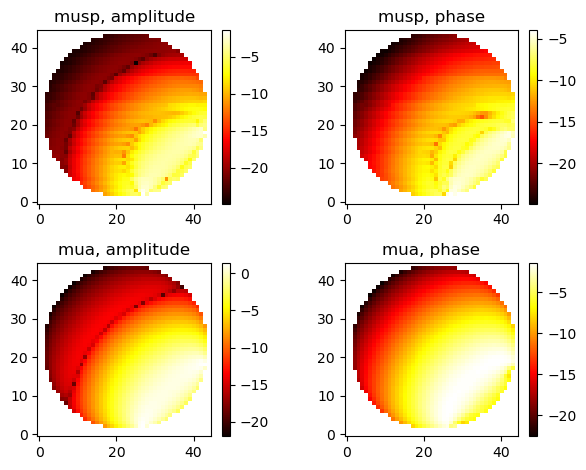

In [7]:
fig, axs = plt.subplots(2,2)
plt.set_cmap('hot')
h1 = axs[0,0].imshow(np.log(np.abs(J1[2*2,:].reshape((45,45),order='F'))), origin='lower')
axs[0,0].set_title('musp, amplitude')
fig.colorbar(h1, fraction=0.046, pad=0.04)

h2 = axs[0,1].imshow(np.log(np.abs(J1[2*2+1,:].reshape((45,45),order='F'))), origin='lower')
axs[0,1].set_title('musp, phase')
fig.colorbar(h2, fraction=0.046, pad=0.04)

h3 = axs[1,0].imshow(np.log(np.abs(J2[2*2,:].reshape((45,45),order='F'))), origin='lower')
axs[1,0].set_title('mua, amplitude')
fig.colorbar(h3, fraction=0.046, pad=0.04)

h4 = axs[1,1].imshow(np.log(np.abs(J2[2*2+1,:].reshape((45,45),order='F'))), origin='lower')
axs[1,1].set_title('mua, phase')
fig.colorbar(h4, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

## Fluorescence
Now let's take a look at the fluorescence mesh.

In the CW fluorescence case, the Jacobian is almost exactly the same as the CW standard case, except that by default, the data type is Born ratio, and the derivatives are calculated with regard to $\eta\mu_{af}$ (that is, mesh.eta*mesh.muaf), instead of $\mu_a$. 

"Born ratio" simply means the channel-wise ratio between the fluorescence emission and the excitation field. This is done to eliminate the impact of non-uniform detector coupling (e.g. different detector fibers have different losses) in the system, under the assumption that the coupling can be approximated as a scaling factor, and is approximately the same at both wavelengths. For the curious reader, a detailed description can be found [here](https://doi.org/10.1364/OE.15.006696). (SIde note: Naming the method "Born ratio" has also received criticism, e.g. [here](https://doi.org/10.1117/1.jbo.17.3.036013))

Let's do the very same things and have a look at the bananas and flat field imaging.

In [8]:
mesh = ff.base.fluormesh()
mesh.from_file('../meshes/fl/circle2000_86_fl')
xgrid = np.arange(-45., 45, 2)
ygrid = np.arange(-45., 45, 2)
mesh.gen_intmat(xgrid, ygrid)

J = mesh.jacobian()[0]

Sources integration functions loaded
Detectors integration functions loaded
Calculating direct field...
Calculating adjoint field...
Integrating...


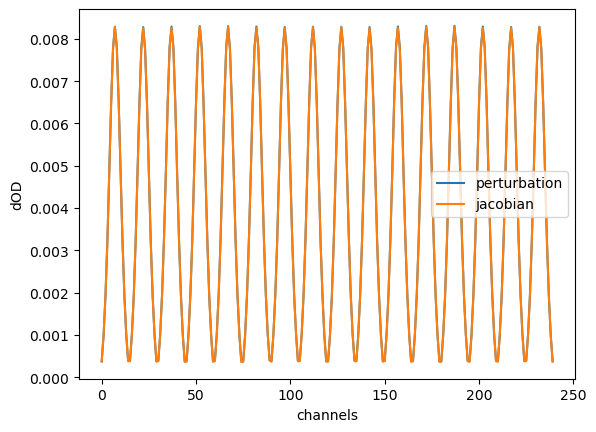

In [9]:
# flat field
mesh2 = ff.base.fluormesh()
mesh2.from_copy(mesh)
gamma = mesh.eta*mesh.muaf
mesh2.muaf = gamma*1.01/mesh.eta # gamma increases by 1%; we can also directly change the optical properties like this
# calculate the forward data and then the difference
data1 = mesh.femdata(0)[0]
data2 = mesh2.femdata(0)[0]
d_data_pert = data2.amplitudefl/data2.amplitudex - data1.amplitudefl/data1.amplitudex # This is called the Born ratio
# Now use the Jacobian method
dmua = 0.01*gamma[0]*np.ones(xgrid.size * ygrid.size)
d_data_jacobian = J @ dmua
# Plot them together
plt.figure()
plt.plot(d_data_pert)
plt.plot(d_data_jacobian)
plt.legend(['perturbation', 'jacobian'])
plt.xlabel('channels')
plt.ylabel('dOD')
plt.show()

/tmp/ipykernel_4663/3784795292.py:2: RuntimeWarning: divide by zero encountered in log
  h = plt.imshow(np.log(np.abs(J[2,:].reshape((45,45),order='F'))), origin='lower')


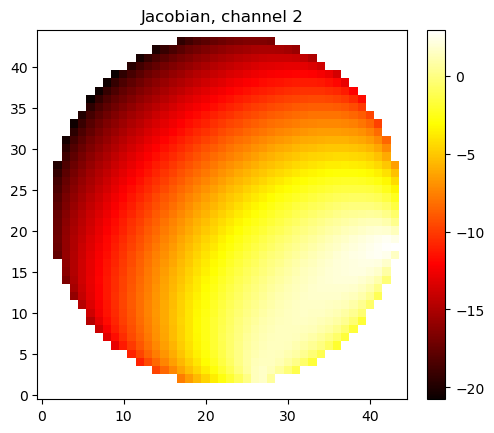

In [10]:
plt.set_cmap('hot')
h = plt.imshow(np.log(np.abs(J[2,:].reshape((45,45),order='F'))), origin='lower')
plt.title('Jacobian, channel 2')
plt.colorbar(h, fraction=0.046, pad=0.04)
plt.show()

Similar to the standard mesh, using frequency-domain Jacobian allows us to reconstruct another parameter, and in this case, it is the fluorescence life time $\tau$ (that is, mesh.tau). How the package handles the data is that we first calculate the derivatives with regard to $\frac{\eta\mu_{af}}{1+j\omega\tau}$, and then apply chain rule to separate $\gamma$ and $\tau$. A detailed discussion can be found [here](https://doi.org/10.1364/JOSAA.21.001035).

In the returned Jacobian, the left half contains the derivatives of $\gamma$, and the right half contains the derivatives of $\tau$. Like the FD standard mesh case, the rows are returned in an interleaved fashion: the odd number rows (counting from 1) are the derivatives of the real part, and the even number rows are the derivatives of the imaginery part. Let's have a look.

In [11]:
import importlib
importlib.reload(ff.inverse)
mesh.tau = 2e-9*np.ones(mesh.nodes.shape[0]) # tau is by default 0; let's give it some non-zero value
J = mesh.jacobian(1e8)[0]

# let's separate the two halves
J1 = J[:, :xgrid.size * ygrid.size]
J2 = J[:, xgrid.size * ygrid.size:]

Calculating direct field...
Calculating adjoint field...
Integrating...


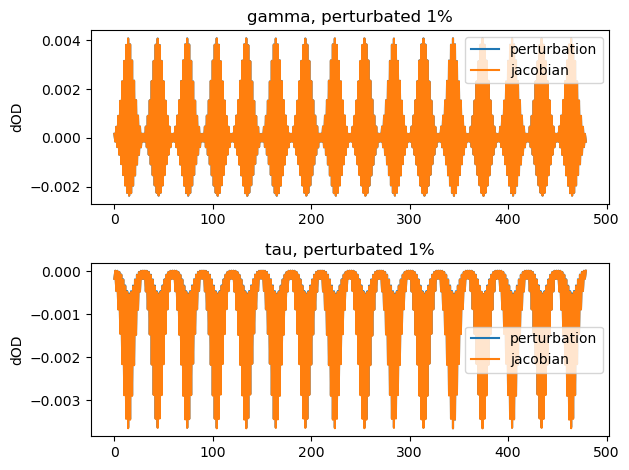

In [12]:
# flat field, gamma
mesh2 = ff.base.fluormesh()
mesh2.from_copy(mesh)
omega = 2*np.pi*1e8
gamma = mesh.eta*mesh.muaf
mesh2.muaf = gamma*1.01/mesh.eta # gamma increases by 1%
# calculate the forward data and then the difference
data1 = mesh.femdata(1e8)[0]
data2 = mesh2.femdata(1e8)[0]
d_data_pert1 = data2.complexfl/data2.complexx - data1.complexfl/data1.complexx
d_data_pert_interleave1 = np.c_[np.real(d_data_pert1), np.imag(d_data_pert1)].flatten()
# Now use the Jacobian method
dmua = 0.01*gamma[0]*np.ones(xgrid.size * ygrid.size)
d_data_jacobian1 = J1 @ dmua

# flat field, tau
mesh2 = ff.base.fluormesh()
mesh2.from_copy(mesh)
mesh2.tau *= 1.01 # 1% tau change
# calculate the forward data and then the difference
data1 = mesh.femdata(1e8)[0]
data2 = mesh2.femdata(1e8)[0]
d_data_pert2 = data2.complexfl/data2.complexx - data1.complexfl/data1.complexx
d_data_pert_interleave2 = np.c_[np.real(d_data_pert2), np.imag(d_data_pert2)].flatten()
# Now use the Jacobian method
dtau = 0.01*mesh.tau[0]*np.ones(xgrid.size * ygrid.size)
d_data_jacobian2 = J2 @ dtau

# plot
fig, (ax1, ax2) = plt.subplots(2)

ax1.plot(d_data_pert_interleave1)
ax1.plot(d_data_jacobian1)
ax1.set_title('gamma, perturbated 1%')
ax1.set_ylabel('dOD')
ax1.legend(['perturbation', 'jacobian'])

ax2.plot(d_data_pert_interleave2)
ax2.plot(d_data_jacobian2)
ax2.set_title('tau, perturbated 1%')
ax2.set_ylabel('dOD')
ax2.legend(['perturbation', 'jacobian'])

plt.tight_layout()
plt.show()

And the bananas

/tmp/ipykernel_4663/3072758194.py:3: RuntimeWarning: divide by zero encountered in log
  h1 = axs[0,0].imshow(np.log(np.abs(J1[2*2,:].reshape((45,45),order='F'))), origin='lower')
/tmp/ipykernel_4663/3072758194.py:7: RuntimeWarning: divide by zero encountered in log
  h2 = axs[0,1].imshow(np.log(np.abs(J1[2*2+1,:].reshape((45,45),order='F'))), origin='lower')
/tmp/ipykernel_4663/3072758194.py:11: RuntimeWarning: divide by zero encountered in log
  h3 = axs[1,0].imshow(np.log(np.abs(J2[2*2,:].reshape((45,45),order='F'))), origin='lower')
/tmp/ipykernel_4663/3072758194.py:15: RuntimeWarning: divide by zero encountered in log
  h4 = axs[1,1].imshow(np.log(np.abs(J2[2*2+1,:].reshape((45,45),order='F'))), origin='lower')


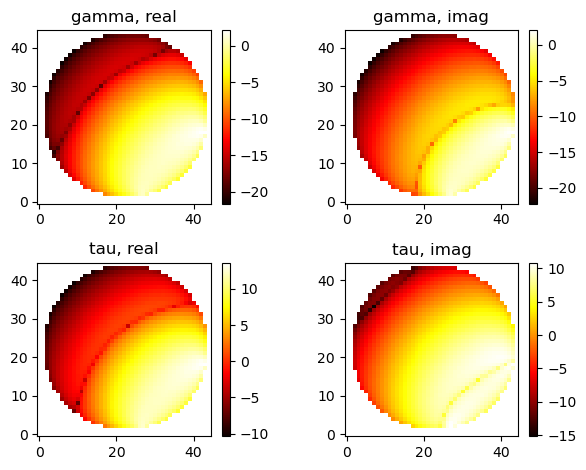

In [13]:
fig, axs = plt.subplots(2,2)
plt.set_cmap('hot')
h1 = axs[0,0].imshow(np.log(np.abs(J1[2*2,:].reshape((45,45),order='F'))), origin='lower')
axs[0,0].set_title('gamma, real')
fig.colorbar(h1, fraction=0.046, pad=0.04)

h2 = axs[0,1].imshow(np.log(np.abs(J1[2*2+1,:].reshape((45,45),order='F'))), origin='lower')
axs[0,1].set_title('gamma, imag')
fig.colorbar(h2, fraction=0.046, pad=0.04)

h3 = axs[1,0].imshow(np.log(np.abs(J2[2*2,:].reshape((45,45),order='F'))), origin='lower')
axs[1,0].set_title('tau, real')
fig.colorbar(h3, fraction=0.046, pad=0.04)

h4 = axs[1,1].imshow(np.log(np.abs(J2[2*2+1,:].reshape((45,45),order='F'))), origin='lower')
axs[1,1].set_title('tau, imag')
fig.colorbar(h4, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

## DCS
Finally, let's examine at the Jacobian matrix of DCS mesh. If we recall the discussion of DCS forward data in the previous part of the tutorial, we know that the underlying mathematics very closely resembles that of the continuous wave data. The Jacobian is consequently also very similar, except that 1) it is now calculated at every point in the time vector, 2) the measurement type is now G1 curve, instead of fluence, and 3) the derivatives are calculated with regard to $\alpha Db$, i.e. the term governing Brownian motion.

Let's have a look at one of Jacobians as an example.

In [14]:
mesh = ff.base.dcsmesh()
mesh.from_file('../meshes/dcs/slab_dcs')
# define the time vector. It is usually a good idea to use log scale
tau = np.logspace(-7,-3,128)
xgrid = np.arange(0., 120, 2)
ygrid = np.arange(0., 120, 2)
zgrid = np.arange(0., 50, 2)
mesh.gen_intmat(xgrid, ygrid, zgrid)
J = mesh.jacobian(tau)[0]

Sources integration functions loaded
Detectors integration functions loaded
Calculating direct field...
Calculating adjoint field...
Integrating...


In [16]:
Jtmp = J[:,:,64]
# flat field
mesh2 = ff.base.dcsmesh()
mesh2.from_copy(mesh)
mesh2.aDb *= 1.01

data1 = mesh.femdata(tau)[0]
data2 = mesh2.femdata(tau)[0]


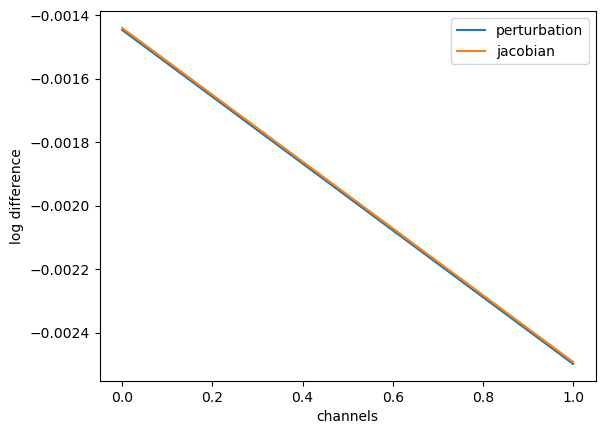

In [17]:
d_data_pert = np.log(data2.G1_DCS[:,64]) - np.log(data1.G1_DCS[:,64])
d_aDb = 0.01 * mesh.aDb[0] * np.ones(xgrid.size*ygrid.size*zgrid.size)
d_data_jacobian = Jtmp @ d_aDb

plt.figure()
plt.plot(d_data_pert)
plt.plot(d_data_jacobian)
plt.legend(['perturbation', 'jacobian'])
plt.xlabel('channels')
plt.ylabel('log difference')
plt.show()

And finally the banana

/tmp/ipykernel_4663/812176839.py:3: RuntimeWarning: divide by zero encountered in log
  h = plt.imshow(np.log(np.abs(banana[30,:,:])).T, origin='lower')


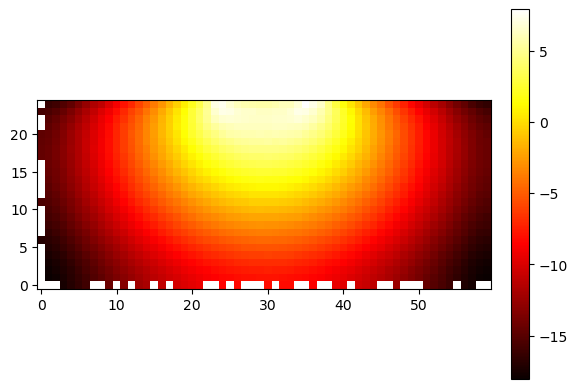

In [18]:
banana = Jtmp[1,:].reshape((xgrid.size, ygrid.size, zgrid.size), order='f')
plt.set_cmap('hot')
h = plt.imshow(np.log(np.abs(banana[30,:,:])).T, origin='lower')
plt.colorbar(h, fraction=0.046, pad=0.04)
plt.show()

That's it! Hope you have learned how to calculate the Jacobians for different mesh types, and gained some understanding of the physical meanings behind them. In the next tutorial, we will discuss how to utilize the Jacobian matrices to perform DOT reconstruction.